In [1]:
from typing import Any, Dict, List, Union, Tuple

import numpy as np
import pandas as pd
from pandas import DataFrame
from types import ModuleType

!pip install scikit-learn
!pip install boto3
import boto3
import json
import re
import importlib
import sys
import os
import re
import ast
from numpy import arange
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

!pip install statsmodels
import statsmodels.api as sm

!pip install matplotlib
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest

  Using cached scikit_learn-1.4.1.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached threadpoolctl-3.3.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.4.1.post1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
Using cached threadpoolctl-3.3.0-py3-none-any.whl (17 kB)


In [2]:
CLUSTER_PATHS = {
    "BASE": "s3://asc-clickstream-emr-output/",
    "INPUT": "preprocessed_project_output/{provider}/{dataset}/"
    "year={year}/month={month}/day={day}/domainBucket={domainBucket}/*",
    "OUTPUT": "s3://asc-clickstream-emr-output/monitoring/preproc/dataset_version={dataset}/",
    "HISTORY": "s3://asc-clickstream-emr-output/monitoring/preproc_reg_history/dataset_version={dataset}/",
}

TOP_10_PREPROC_CLICKS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/" "top_datasets/PREPROC_10_row_datasets.json"
)
TOP_10_PREPROC_PANELISTS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_datasets/" "PREPROC_10_panelist_datasets.json"
)
TOP_5_PREPROC_CLICKS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_datasets/" "PREPROC_5_row_datasets.json"
)
TOP_5_PREPROC_PANELISTS_DATASETS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_datasets/" "PREPROC_5_panelist_datasets.json"
)
TOP_10_PREPROC_CLICKS_DOMAINS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "PREPROC_10_row_domains.json"
)
TOP_10_PREPROC_PANELISTS_DOMAINS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "PREPROC_10_panelist_domains.json"
)
TOP_5_PREPROC_CLICKS_DOMAINS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "PREPROC_5_row_domains.json"
)
TOP_5_PREPROC_PANELISTS_DOMAINS = (
    "s3://asc-clickstream-emr-output/monitoring/resources/top_domains/" "PREPROC_5_panelist_domains.json"
)

PROVIDER = "Datos"
BLACKLIST_DOMAINS = ["exacttarget"]
blacklist_domains: List[str] = BLACKLIST_DOMAINS
metrics: List[str] = []

In [3]:
# 1. Load top Clicks and Panelists datasets
def load_json(path: str) -> Any:
    s3 = boto3.resource("s3")
    split_path = path.split("://")[1].split("/")
    bucket = split_path[0]
    key = "/".join(split_path[1:])
    content_object = s3.Object(bucket, key)
    file_content = content_object.get()["Body"].read().decode("utf-8")
    json_file = json.loads(file_content)
    return json_file

top_10_row_datasets = load_json(TOP_10_PREPROC_CLICKS_DATASETS)["datasets"]
top_10_panelist_datasets = load_json(TOP_10_PREPROC_PANELISTS_DATASETS)["datasets"]

top_5_row_datasets = load_json(TOP_5_PREPROC_CLICKS_DATASETS)["datasets"]
top_5_panelist_datasets = load_json(TOP_5_PREPROC_PANELISTS_DATASETS)["datasets"]

top_10_row_domains = load_json(TOP_10_PREPROC_CLICKS_DOMAINS)["domains"]
top_10_panelist_domains = load_json(TOP_10_PREPROC_PANELISTS_DOMAINS)["domains"]

top_5_row_domains = load_json(TOP_5_PREPROC_CLICKS_DOMAINS)["domains"]
top_5_panelist_domains = load_json(TOP_5_PREPROC_PANELISTS_DOMAINS)["domains"]

In [4]:
# 2. Loading historic data from monitoring in the form of JSONs; this data is used for training the model

# S3 bucket details
bucket_name = 'asc-clickstream-emr-output'
prefix = 'monitoring/preproc_reg_history/dataset_version=dataset576_V6_1/year=2024/'  # Optional: Specify a prefix for the path in the bucket

# Create an S3 client (No need to provide access key and secret key if credentials are available)
s3_client = boto3.client('s3')

# List objects in the bucket
objects = s3_client.list_objects(Bucket=bucket_name, Prefix=prefix)
#print(objects)

# Loop through each object and load JSON into Pandas DataFrame
columns = ['name', 'result', 'dataset', 'domain', 'date', 'predicted', 'z_score', 'diff', 'percent_diff', 'threshold',
              'verdict_day', 'verdict_cur', 'verdict']
dfs = []
for obj in objects.get('Contents', []):
    key = obj['Key']
    response = s3_client.get_object(Bucket=bucket_name, Key=key)
    content = response['Body'].read().decode('utf-8')
    actual_list = ast.literal_eval(content)
    #print(type(actual_list))
    dfs.extend(actual_list)

In [5]:
df = DataFrame(dfs)

In [6]:
df = df.sort_values(by=["date"]).reset_index(drop=True)

In [7]:
df

,name,result,dataset,domain,date,predicted,z_score,diff,percent_diff,threshold,verdict_day,verdict_cur,verdict
0,count_unique_panelists_per_dataset,0.000000e+00,dataset33,All,1704067200000,0.000000e+00,0.000000,0.000000,0.000000,2,MISSING,MISSING,MISSING
1,count_unique_panelists_per_dataset,0.000000e+00,dataset80,All,1704067200000,0.000000e+00,0.000000,0.000000,0.000000,2,MISSING,MISSING,MISSING
2,count_unique_panelists_per_dataset,0.000000e+00,dataset20,All,1704067200000,2.186984e+02,10.873629,-218.698440,-1.000000,2,MISSING,MISSING,MISSING
3,count_unique_panelists_per_dataset,0.000000e+00,dataset89,All,1704067200000,0.000000e+00,0.000000,0.000000,0.000000,2,MISSING,MISSING,MISSING
4,count_unique_panelists_per_dataset,0.000000e+00,dataset856,All,1704067200000,0.000000e+00,0.000000,0.000000,0.000000,2,MISSING,MISSING,MISSING
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7423,count_rows_per_dataset,1.949226e+06,dataset46,All,1709424000000,2.033459e+06,1.528335,-84232.688000,-0.041423,2,NaN,NaN,OK
7424,count_rows_per_dataset,1.064700e+04,dataset451,All,1709424000000,1.661866e+04,3.484169,-5971.661258,-0.359335,2,NaN,NaN,NOK
7425,count_valid_clicks_ratio_per_dataset,9.642703e-01,dataset1436,All,1709424000000,1.000000e+00,100.000000,-0.035730,-0.035730,2,NaN,NaN,NOK
7426,count_valid_clicks_ratio_per_dataset,9.720158e-01,dataset30,All,1709424000000,1.000000e+00,100.000000,-0.027984,-0.027984,2,NaN,NaN,NOK


In [10]:
from datetime import datetime

# Milliseconds timestamp
milliseconds_timestamp = 1709424000000	

# Convert milliseconds to seconds
seconds_timestamp = milliseconds_timestamp / 1000.0

# Convert to datetime object
datetime_object = datetime.utcfromtimestamp(seconds_timestamp)

print(datetime_object)

##############################################################

# Define the date
date_str = "2024-02-03"

# Convert the date string to a datetime object
date_obj = datetime.strptime(date_str, "%Y-%m-%d")

# Convert the datetime object to a timestamp (in seconds)
timestamp = datetime.timestamp(date_obj)

# Convert the timestamp to milliseconds
milliseconds = int(timestamp * 1000)

print(milliseconds)

2024-03-03 00:00:00
1706918400000


In [8]:
unique_values_name = df['name'].unique()
unique_values_name

array(['count_unique_panelists_per_dataset', 'count_rows_per_dataset',
       'count_rows', 'count_valid_clicks_ratio_per_dataset',
       'count_unique_panelists'], dtype=object)

In [11]:
# count rows
count_rows = df[(df['name'] == 'count_rows')]
count_rows_per_dataset = df[(df['name'] == 'count_rows_per_dataset')]

# count unique panelists
count_unique_panelists = df[(df['name'] == 'count_unique_panelists')]
count_unique_panelists_per_dataset = df[(df['name'] == 'count_unique_panelists_per_dataset')]

# count valid clicks ratio
count_valid_clicks_ratio_per_dataset = df[(df['name'] == 'count_valid_clicks_ratio_per_dataset')]

In [79]:
data = count_valid_clicks_ratio_per_dataset
training_set = data[data["date"] < 1706918400000]
testing_set = data[data["date"] >= 1706918400000]

In [80]:
training_set

,name,result,dataset,domain,date,predicted,z_score,diff,percent_diff,threshold,verdict_day,verdict_cur,verdict
28,count_valid_clicks_ratio_per_dataset,0.999393,dataset30,All,1704067200000,1.0,100.0,-0.000607,-0.000607,2,NOK,NOK,NOK
29,count_valid_clicks_ratio_per_dataset,0.998625,dataset45,All,1704067200000,1.0,100.0,-0.001375,-0.001375,2,NOK,NOK,NOK
30,count_valid_clicks_ratio_per_dataset,0.995996,dataset48,All,1704067200000,1.0,100.0,-0.004004,-0.004004,2,NOK,NOK,NOK
31,count_valid_clicks_ratio_per_dataset,0.994026,dataset747,All,1704067200000,1.0,100.0,-0.005974,-0.005974,2,NOK,NOK,NOK
32,count_valid_clicks_ratio_per_dataset,0.999399,dataset91,All,1704067200000,1.0,100.0,-0.000601,-0.000601,2,NOK,NOK,NOK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,count_valid_clicks_ratio_per_dataset,0.988849,dataset46,All,1706832000000,1.0,100.0,-0.011151,-0.011151,2,NaN,NaN,NOK
3819,count_valid_clicks_ratio_per_dataset,0.997133,other,All,1706832000000,1.0,100.0,-0.002867,-0.002867,2,NaN,NaN,NOK
3821,count_valid_clicks_ratio_per_dataset,0.998166,dataset45,All,1706832000000,1.0,100.0,-0.001834,-0.001834,2,NaN,NaN,NOK
3822,count_valid_clicks_ratio_per_dataset,0.999091,dataset48,All,1706832000000,1.0,100.0,-0.000909,-0.000909,2,NaN,NaN,NOK


In [81]:
data = training_set.copy()
data = data.sort_values(by=["date"]).reset_index(drop=True)
data["dow"] = data["date"].apply(lambda x: pd.to_datetime(x).weekday())
data["const"] = 1
data["trend"] = data.index + 1
data["is_monday"] = data["dow"].apply(lambda x: 1 if x == 0 else 0)
data["is_tuesday"] = data["dow"].apply(lambda x: 1 if x == 1 else 0)
data["is_wednesday"] = data["dow"].apply(lambda x: 1 if x == 2 else 0)
data["is_thursday"] = data["dow"].apply(lambda x: 1 if x == 3 else 0)
data["is_friday"] = data["dow"].apply(lambda x: 1 if x == 4 else 0)
data["is_saturday"] = data["dow"].apply(lambda x: 1 if x == 5 else 0)

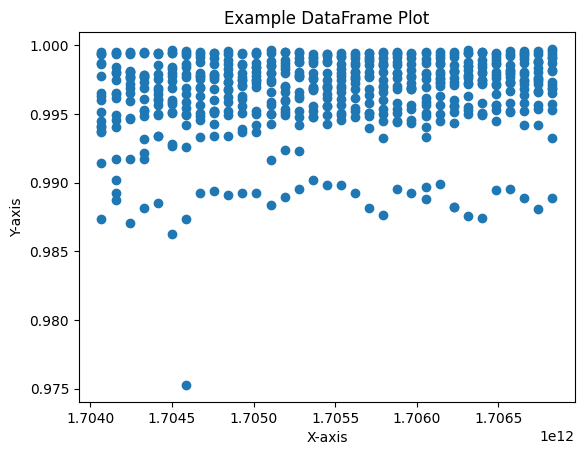

In [82]:
plt.scatter(data["date"], data["result"])
plt.title('Example DataFrame Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

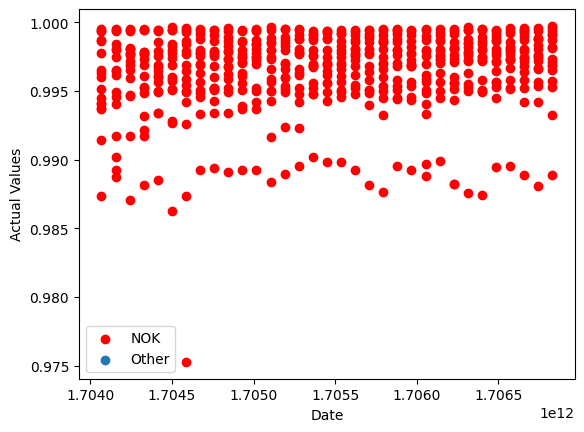

In [83]:
# Separate data based on verdict
nok_data = data[data["verdict"] == "NOK"]
other_data = data[data["verdict"] != "NOK"]

# Plot points for "NOK" verdicts with red color
plt.scatter(nok_data["date"], nok_data["result"], label='NOK', color='red')

# Plot points for other verdicts with default color
plt.scatter(other_data["date"], other_data["result"], label='Other')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Actual Values')
plt.legend()

# Show plot
plt.show()

In [84]:
X = data[["const", "trend", "is_monday", "is_tuesday", "is_wednesday", "is_thursday", "is_friday", "is_saturday"]].astype("int")
y = data["result"].astype("float")

In [85]:
# HuberT Robust Linear Regression
rlm_model_huberT = sm.RLM(y, X, M=sm.robust.norms.HuberT())
rlm_results_huberT = rlm_model_huberT.fit()
rlm_results_huberT.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  561
Model:                            RLM   Df Residuals:                      559
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        21:28:49                                         
No. Iterations:                    19                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4982   8.84e-05   5633.207      0.000       0.498       0.498
trend         1.736e-06   5.45e-07      3.182      0.001    6.67e-07     2.8e-06
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday      0.4982   8.84e-05   5633.207      0.000       0.498       0.498
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [86]:
# Trimmed Mean Robust Linear Regression
rlm_model_trimmed_mean = sm.RLM(y, X, M=sm.robust.norms.TrimmedMean())
rlm_results_trimmed_mean = rlm_model_trimmed_mean.fit()
rlm_results_trimmed_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  561
Model:                            RLM   Df Residuals:                      559
Method:                          IRLS   Df Model:                            1
Norm:                     TrimmedMean                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        21:28:50                                         
No. Iterations:                     5                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4984   7.54e-05   6608.766      0.000       0.498       0.499
trend         1.285e-06   4.65e-07      2.764      0.006    3.74e-07     2.2e-06
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday      0.4984   7.54e-05   6608.766      0.000       0.498       0.499
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [87]:
# Andrew Wave Robust Linear Regression
rlm_model_andrew_wave = sm.RLM(y, X, M=sm.robust.norms.AndrewWave())
rlm_results_andrew_wave = rlm_model_andrew_wave.fit()
rlm_results_andrew_wave.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  561
Model:                            RLM   Df Residuals:                      559
Method:                          IRLS   Df Model:                            1
Norm:                      AndrewWave                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        21:28:51                                         
No. Iterations:                    18                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4983   9.14e-05   5449.079      0.000       0.498       0.498
trend         1.816e-06   5.64e-07      3.220      0.001    7.11e-07    2.92e-06
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday      0.4983   9.14e-05   5449.079      0.000       0.498       0.498
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [88]:
# RamsayE Robust Linear Regression
rlm_model_ramsayE = sm.RLM(y, X, M=sm.robust.norms.RamsayE())
rlm_results_ramsayE = rlm_model_ramsayE.fit()
rlm_results_ramsayE.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  561
Model:                            RLM   Df Residuals:                      559
Method:                          IRLS   Df Model:                            1
Norm:                         RamsayE                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        21:28:52                                         
No. Iterations:                    16                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4982    9.9e-05   5033.894      0.000       0.498       0.498
trend         1.894e-06    6.1e-07      3.104      0.002    6.98e-07    3.09e-06
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday      0.4982    9.9e-05   5033.894      0.000       0.498       0.498
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [89]:
# Tukey Biweight Robust Linear Regression
rlm_model_tukey_biweight = sm.RLM(y, X, M=sm.robust.norms.TukeyBiweight())
rlm_results_tukey_biweight = rlm_model_tukey_biweight.fit()
rlm_results_tukey_biweight.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  561
Model:                            RLM   Df Residuals:                      559
Method:                          IRLS   Df Model:                            1
Norm:                   TukeyBiweight                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        21:28:53                                         
No. Iterations:                    19                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4983   9.09e-05   5478.569      0.000       0.498       0.498
trend         1.805e-06   5.61e-07      3.219      0.001    7.06e-07     2.9e-06
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday      0.4983   9.09e-05   5478.569      0.000       0.498       0.498
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [90]:
# Least Squares Robust Linear Regression
rlm_model_least_squares = sm.RLM(y, X, M=sm.robust.norms.LeastSquares())
rlm_results_least_squares = rlm_model_least_squares.fit()
rlm_results_least_squares.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  561
Model:                            RLM   Df Residuals:                      559
Method:                          IRLS   Df Model:                            1
Norm:                    LeastSquares                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        21:28:54                                         
No. Iterations:                     3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4980      0.000   4112.390      0.000       0.498       0.498
trend         2.104e-06   7.47e-07      2.818      0.005    6.41e-07    3.57e-06
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday      0.4980      0.000   4112.390      0.000       0.498       0.498
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [91]:
# Robust Norm Hampel Linear Regression
rlm_model_hampel = sm.RLM(y, X, M=sm.robust.norms.Hampel())
rlm_results_hampel = rlm_model_hampel.fit()
rlm_results_hampel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                 result   No. Observations:                  561
Model:                            RLM   Df Residuals:                      559
Method:                          IRLS   Df Model:                            1
Norm:                          Hampel                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 05 Mar 2024                                         
Time:                        21:28:55                                         
No. Iterations:                    15                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4981   9.77e-05   5099.628      0.000       0.498       0.498
trend         1.882e-06   6.02e-07      3.125      0.002    7.02e-07    3.06e-06
is_monday             0          0        nan        nan           0           0
is_tuesday            0          0        nan        nan           0           0
is_wednesday          0          0        nan        nan           0           0
is_thursday      0.4981   9.77e-05   5099.628      0.000       0.498       0.498
is_friday             0          0        nan        nan           0           0
is_saturday           0          0        nan        nan           0           0
================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [92]:
if len(testing_set) < len(training_set):
    predicted_values_huberT = rlm_results_huberT.predict()[:len(testing_set)]
    predicted_values_trimmed_mean = rlm_results_trimmed_mean.predict()[:len(testing_set)]
    predicted_values_andrew_wave = rlm_results_andrew_wave.predict()[:len(testing_set)]
    predicted_values_ramsayE = rlm_results_ramsayE.predict()[:len(testing_set)]
    predicted_values_tukey_biweight = rlm_results_tukey_biweight.predict()[:len(testing_set)]
    predicted_values_least_squares = rlm_results_least_squares.predict()[:len(testing_set)]
    predicted_values_hampel = rlm_results_hampel.predict()[:len(testing_set)]
else:
    testing_set = testing_set[:len(training_set)]
    predicted_values_huberT = rlm_results_huberT.predict()[:len(testing_set)]
    predicted_values_trimmed_mean = rlm_results_trimmed_mean.predict()[:len(testing_set)]
    predicted_values_andrew_wave = rlm_results_andrew_wave.predict()[:len(testing_set)]
    predicted_values_ramsayE = rlm_results_ramsayE.predict()[:len(testing_set)]
    predicted_values_tukey_biweight = rlm_results_tukey_biweight.predict()[:len(testing_set)]
    predicted_values_least_squares = rlm_results_least_squares.predict()[:len(testing_set)]
    predicted_values_hampel = rlm_results_hampel.predict()[:len(testing_set)]

In [93]:
def mse_mae(testing_set, predicted_values):
    #predicted_values = predicted_values[:len(testing_set)]
    mae = 0
    mse = 0
    c = 0

    for i in range(len(testing_set)):
      mse += (testing_set.result.iloc[i] - predicted_values[i])**2
      mae += abs(testing_set.result.iloc[i] - predicted_values[i])
      c += 1

    return ["{:.4e}".format(mse / c), "{:.4e}".format(mae / c), "{:.4e}".format((mse/c)**(1/2))]

table = pd.DataFrame(columns=["MSE", "MAE", "RMSE"])
table.loc["HuberT"] = mse_mae(testing_set, predicted_values_huberT)
table.loc["Trimmed Mean"] = mse_mae(testing_set, predicted_values_trimmed_mean)
table.loc["Andrew Wave"] = mse_mae(testing_set, predicted_values_andrew_wave)
table.loc["RamsayE"] = mse_mae(testing_set, predicted_values_ramsayE)
table.loc["Tukey Biweight"] = mse_mae(testing_set, predicted_values_tukey_biweight)
table.loc["Least Squares"] = mse_mae(testing_set, predicted_values_least_squares)
table.loc["Hampel"] = mse_mae(testing_set, predicted_values_hampel)

table

,MSE,MAE,RMSE
HuberT,5.8462e-04,1.5350e-02,2.4179e-02
Trimmed Mean,5.9064e-04,1.5375e-02,2.4303e-02
Andrew Wave,5.8847e-04,1.5384e-02,2.4258e-02
RamsayE,5.8429e-04,1.5356e-02,2.4172e-02
Tukey Biweight,5.8831e-04,1.5382e-02,2.4255e-02
Least Squares,5.7544e-04,1.5308e-02,2.3988e-02
Hampel,5.8166e-04,1.5336e-02,2.4118e-02


In [46]:
count_rows_per_dataset_table
count_rows_tables
count_unique_panelists_table
count_unique_panelists_per_dataset_table
count_valid_clicks_ratio_per_dataset_table

,MSE,MAE,RMSE
HuberT,7.5684e+12,2.1236e+06,2.7511e+06
Trimmed Mean,7.6125e+12,2.0223e+06,2.7591e+06
Andrew Wave,7.5660e+12,2.1027e+06,2.7506e+06
RamsayE,7.5670e+12,2.1122e+06,2.7508e+06
Tukey Biweight,7.5660e+12,2.1028e+06,2.7506e+06
Least Squares,7.7384e+12,2.2633e+06,2.7818e+06
Hampel,7.6438e+12,2.2073e+06,2.7647e+06


In [116]:
combined_table = pd.concat([count_rows_per_dataset_table, count_rows_tables, count_unique_panelists_table, 
                            count_unique_panelists_per_dataset_table, count_valid_clicks_ratio_per_dataset_table])
averages = pd.DataFrame(columns=["MSE", "MAE", "RMSE"])
averages.loc["HuberT"] = combined_table.loc['HuberT', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Trimmed Mean"] = combined_table.loc['Trimmed Mean', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Andrew Wave"] = combined_table.loc['Andrew Wave', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["RamsayE"] = combined_table.loc['RamsayE', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Tukey Biweight"] = combined_table.loc['Tukey Biweight', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Least Squares"] = combined_table.loc['Least Squares', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages.loc["Hampel"] = combined_table.loc['Hampel', ['MSE', 'MAE', 'RMSE']].astype(float).mean()
averages

,MSE,MAE,RMSE
HuberT,1.549178e+13,1.095435e+06,2.259053e+06
Trimmed Mean,1.572612e+13,1.033734e+06,2.276566e+06
Andrew Wave,1.573521e+13,1.046818e+06,2.275925e+06
RamsayE,1.558563e+13,1.074633e+06,2.265691e+06
Tukey Biweight,1.573501e+13,1.046858e+06,2.275905e+06
Least Squares,1.514392e+13,1.365197e+06,2.240691e+06
Hampel,1.572009e+13,1.073710e+06,2.275172e+06


In [118]:
sorted_table = averages.sort_values(by='MAE')
sorted_table

,MSE,MAE,RMSE
Trimmed Mean,1.572612e+13,1.033734e+06,2.276566e+06
Andrew Wave,1.573521e+13,1.046818e+06,2.275925e+06
Tukey Biweight,1.573501e+13,1.046858e+06,2.275905e+06
Hampel,1.572009e+13,1.073710e+06,2.275172e+06
RamsayE,1.558563e+13,1.074633e+06,2.265691e+06
HuberT,1.549178e+13,1.095435e+06,2.259053e+06
Least Squares,1.514392e+13,1.365197e+06,2.240691e+06


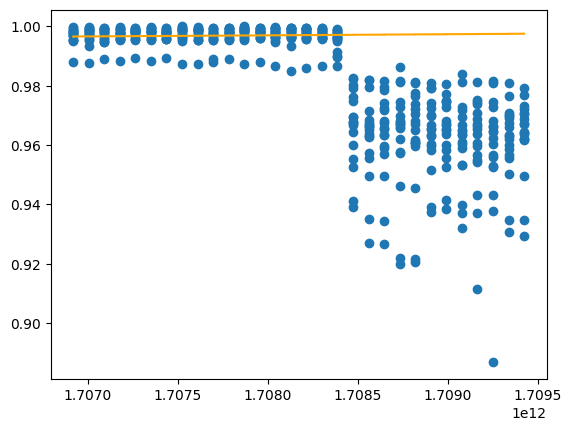

In [119]:
plt.scatter(testing_set["date"], testing_set["result"])
plt.plot(testing_set["date"], predicted_values_andrew_wave, color='orange')
plt.show()

In [120]:
data["predicted"] = rlm_results_andrew_wave.predict(X)
data["diff"] = data["result"] - data["predicted"]  # diff between predictions and reality
data["percent_diff"] = data["diff"] / (data["predicted"] + 1e-6)
data["threshold"] = 2
data["z_score"] = (abs(data["result"] - data["predicted"])) / data["diff"].std()
data["verdict"] = data.apply(lambda x: "OK" if (abs(x["z_score"]) < 2) else "NOK", axis=1)

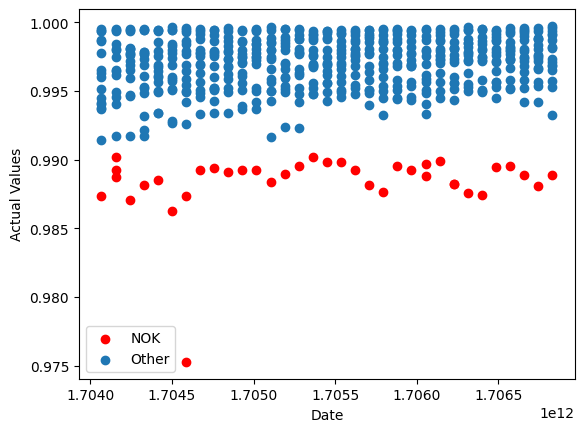

In [121]:
# Separate data based on verdict
nok_data = data[data["verdict"] == "NOK"]
other_data = data[data["verdict"] != "NOK"]

# Plot points for "NOK" verdicts with red color
plt.scatter(nok_data["date"], nok_data["result"], label='NOK', color='red')

# Plot points for other verdicts with default color
plt.scatter(other_data["date"], other_data["result"], label='Other')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Actual Values')
plt.legend()

# Show plot
plt.show()

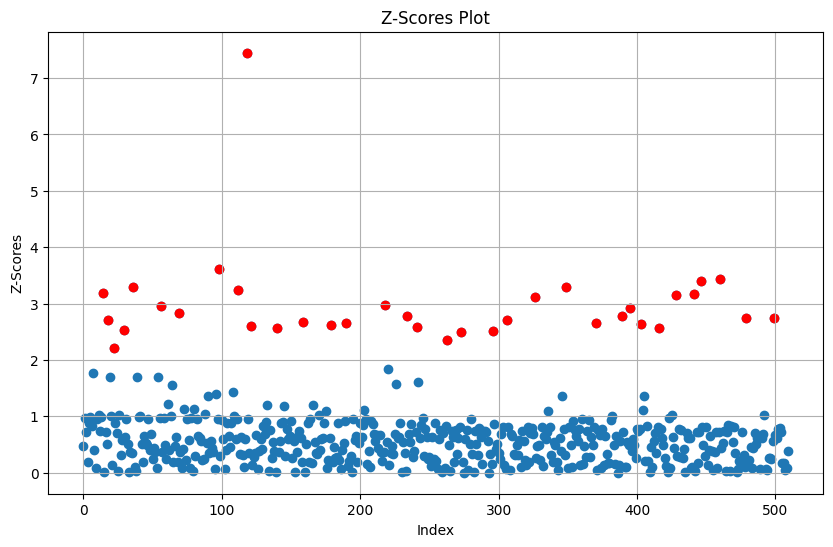

In [270]:
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data["z_score"])
plt.scatter(nok_data.index, nok_data["z_score"], label='NOK', color='red')
plt.title('Z-Scores Plot')
plt.xlabel('Index')
plt.ylabel('Z-Scores')
plt.grid(True)
plt.show()